In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers



Using TensorFlow backend.


In [2]:

path = 'input/'
comp = 'jigsaw-toxic-comment-classification-challenge/'
EMBEDDING_FILE=f'{path}glove.6B.50d.txt'
TRAIN_DATA_FILE=f'{path}train.csv'
TEST_DATA_FILE=f'{path}test.csv'

In [3]:


# configuring basic parameters

embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use
char_embed_size = 50 # max size of word

In [4]:

# Read in our data and replace missing values:

train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)

list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values



In [5]:
# Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed)

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))




In [6]:
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [7]:
# Read the glove word vectors (space delimited strings) into a dictionary from word->vector.

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding="utf8"))




In [8]:
# Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
print("Mean",emb_mean,"StDiv",emb_std)




c:\users\rms170003\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


Mean 0.020940498 StDiv 0.6441043


In [10]:

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
char_embedding_matrix = np.zeros(((nb_words, char_embed_size)))
# print("words not in glove")
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
#     else:
#         print(word)
    vec=np.zeros(char_embed_size)
    word=word[:char_embed_size]
    wc=0
    for c in word:
        vec[wc]=ord(c)/256.0
        wc+=1
    char_embedding_matrix[i]=vec

In [13]:
# Simple bidirectional LSTM with two fully connected layers. We add some dropout to the LSTM since even 2 epochs is enough to overfit.

inp = Input(shape=(maxlen,))
x = Embedding(max_features, char_embed_size, weights=[char_embedding_matrix])(inp)
# x = Embedding(max_features, embed_size+char_embed_size, weights=[final_embedding_matrix])(inp)

x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
# Now we're ready to fit out model! Use validation_split when not submitting.

model.fit(X_t, y, batch_size=32, epochs=5, validation_split=0.3);


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 111699 samples, validate on 47872 samples
Epoch 1/5
111699/111699 [==============================] - 425s 4ms/step - loss: 0.0667 - acc: 0.9777 - val_loss: 0.0516 - val_acc: 0.9816
Epoch 2/5
111699/111699 [==============================] - 442s 4ms/step - loss: 0.0464 - acc: 0.9829 - val_loss: 0.0517 - val_acc: 0.9818
Epoch 3/5
111699/111699 [==============================] - 433s 4ms/step - loss: 0.0419 - acc: 0.9841 - val_loss: 0.0510 - val_acc: 0.9826
Epoch 4/5
111699/111699 [==============================] - 413s 4ms/step - loss: 0.0380 - acc: 0.9852 - val_loss: 0.0520 - val_acc: 0.9819
Epoch 5/5
111699/111699 [==============================] - 408s 4ms/step - loss: 0.0339 - acc: 0.9867 - val_loss: 0.0528 - val_acc: 0.9818


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 50)           1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 100)          40400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total para

In [16]:
model.history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [17]:
import matplotlib.pyplot as plt
A = range(1,len(model.history.history['acc'])+1)
B = [ round(i,5) for i in model.history.history['acc']]
C = [ round(i,5) for i in model.history.history['val_acc']]

plt.plot(A,B,'--bo')
plt.plot(A,C,'--ro')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# for xy in zip(A, B):                                       # <--
#     plt.annotate('TRN(%s, %s)' % xy, xy=xy, textcoords='data') # <--
# for xy in zip(A, C):                                       # <--
#     plt.annotate('TST(%s, %s)' % xy, xy=xy, textcoords='data') # <--

plt.legend(['train', 'test'], loc='upper left')
plt.show()

<Figure size 640x480 with 1 Axes>

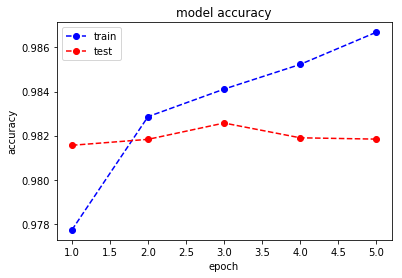

In [18]:
A = range(1,len(model.history.history['acc'])+1)
B = [ round(i,5) for i in model.history.history['acc']]
C = [ round(i,5) for i in model.history.history['val_acc']]
plt.plot(A,B,'--bo')
plt.plot(A,C,'--ro')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# for xy in zip(A, B):                                       # <--
#     plt.annotate('TRN(%s, %s)' % xy, xy=xy, textcoords='data') # <--
# for xy in zip(A, C):                                       # <--
#     plt.annotate('TST(%s, %s)' % xy, xy=xy, textcoords='data') # <--

plt.legend(['train', 'test'], loc='upper left')
plt.show()

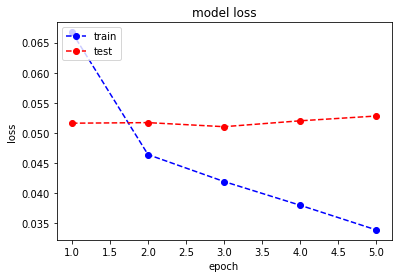

In [19]:
A = range(1,len(model.history.history['loss'])+1)
B = model.history.history['loss']
C = model.history.history['val_loss']
plt.plot(A,B,'--bo')
plt.plot(A,C,'--ro')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def sample_test(S1,model):
    v=tokenizer.texts_to_sequences([S1])
    v=pad_sequences(v,maxlen=maxlen)
    y=list(model.predict([v], batch_size=1024, verbose=1))
    for i in range(6):
        print(y[0][i], list_classes[i])